In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import sys
# sys.path.insert(1, r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
import FCMA as fc
import importlib
import quadpy
from scipy.special import erf
from scipy.integrate import quad_vec
import sympy
fc = importlib.reload(fc)


In [2]:
df = pd.read_csv(r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning\predictions\Muon_Angle_m21_222t_1500k_MC_predictions.csv')

In [3]:
df

,Unnamed: 0,event_no,azimuth,zenith,energy_log10,stopped_muon,muon_track_length,azimuth_pred,zenith_pred,pred_sigma
0,0,138674666.0,1.349233,0.543344,2.781607,0.0,1638.657168,1.269890,0.541098,2.091273
1,1,138675106.0,0.341489,0.812389,2.496842,1.0,1211.095527,0.155887,0.802602,5.306196
2,2,138678783.0,3.998877,0.665721,2.820676,0.0,1824.445392,4.016098,0.660168,1.548202
3,3,138682537.0,2.618876,0.119030,2.705125,0.0,1409.702515,3.117031,0.074725,3.801230
4,4,138685485.0,3.621367,0.544419,3.080137,1.0,1173.661867,3.457797,0.566893,7.235690
...,...,...,...,...,...,...,...,...,...,...
1499995,1499995,140544047.0,2.593930,0.435636,2.465056,1.0,1117.416002,2.601403,0.439520,4.429922
1499996,1499996,140544219.0,1.820517,0.918147,2.090240,1.0,379.463249,1.836564,0.849738,26.435945
1499997,1499997,140546730.0,3.296331,0.867890,2.551116,1.0,378.928062,2.806547,0.666708,34.381626
1499998,1499998,140547193.0,3.112284,0.210568,2.468115,1.0,970.570450,3.526920,0.002221,22.068626


In [4]:
def Omega(azp,zep,azt,zet):
    s1 = np.sin( zet + azt - azp )
    s2 = np.sin( zet - azt + azp )
    c1 = np.cos( zet - zep )
    c2 = np.cos( zet + zep )
    return np.arccos(0.5*np.abs(np.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2))*180/np.pi

O = Omega(df.azimuth_pred,df.zenith_pred,df.azimuth,df.zenith)
df['solidA'] = O

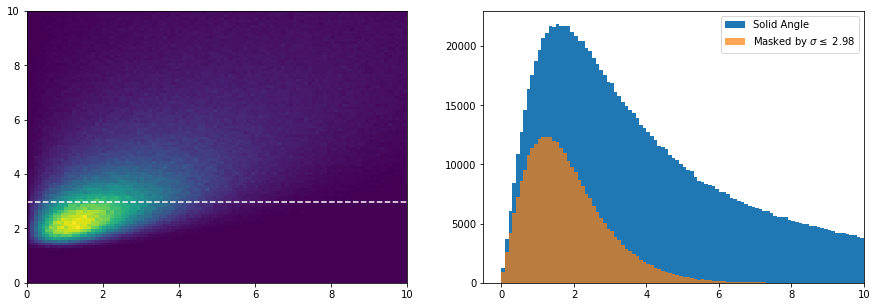

In [5]:
cut = np.quantile(df.pred_sigma,0.2)
O_min, O_max = (0,10)
bins= 100

fig, ax = plt.subplots(figsize=(15,5),ncols=2)
ax[0].hist2d(O,df.pred_sigma,bins=bins,range=((O_min,O_max),(0,10)));
ax[0].hlines(cut,O_min,O_max,color='w',linestyle='--')

ax[1].hist(O,bins=bins,range=(O_min,O_max),label='Solid Angle')
ax[1].hist(O[df.pred_sigma<=cut],bins=bins,range=(O_min,O_max),alpha=0.7,label='Masked by $\sigma \leq$ {:.2f}'.format(cut));
ax[1].set_xlim(ax[1].get_xlim()[0],O_max)
ax[1].legend()

In [6]:
def sample2d(df2d,N,noise=0):
    return df2d.sample(N,replace=True) + np.random.normal(0,noise,(N,2))

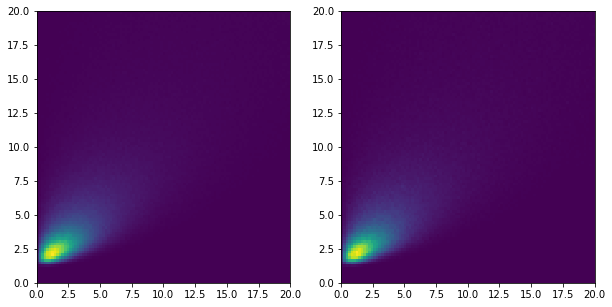

In [7]:
N = int(1.5e6)

sample = sample2d(df[['solidA','pred_sigma']],N,noise=0.01)

xlim = (0,20)
ylim = (0,20)

fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0].hist2d(df.solidA,df.pred_sigma,bins=bins,range=(xlim,ylim));
ax[1].hist2d(sample.solidA,sample.pred_sigma, bins=bins,range=(xlim,ylim));

# Moon simulation

In [8]:
def fan_out(x):
    N = x.shape[0]
    angles = np.random.random(N)*2*np.pi
    tmp = np.zeros((N,2,2))
    sin = np.sin(angles)
    cos = np.cos(angles)
    tmp[:,0,0] = cos
    tmp[:,0,1] = -sin
    tmp[:,1,0] = sin
    tmp[:,1,1] = cos
    xy = np.hstack([x.reshape(N,1),np.zeros((N,1))])
    return np.matmul(xy.reshape(N,1,2),tmp).reshape(N,2)

In [12]:
N = 100_000
xw = 20

signal = np.random.uniform(-xw,xw,(N,2))#(np.random.uniform((N,2)) - 0.5)*2*xw
r = np.sqrt(signal[:,0]**2 + signal[:,1]**2)
mask = (r > 0.5)&(r<xw)
signal = signal[mask]

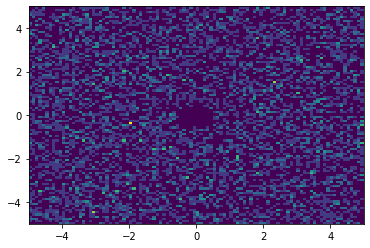

In [13]:
fig, ax = plt.subplots()
lim = 5
ax.hist2d(signal[:,0],signal[:,1],bins=100,range=((-lim,lim),(-lim,lim)));

In [14]:
N = signal.shape[0]
reco = signal.copy()
# sample = sample2d(df[['solidA','pred_sigma']][df.pred_sigma<=cut],N,noise=0.001)
print("DOWNSCALING FOR TESTING, SHOULD BE REMOVED IN FINAL REENDITION")
sample = sample2d(df[['solidA','pred_sigma']][df.pred_sigma<=cut],N,noise=0.001)*0.5
deviation = fan_out(sample.solidA.to_numpy())
reco += deviation

DOWNSCALING FOR TESTING, SHOULD BE REMOVED IN FINAL REENDITION


<ErrorbarContainer object of 3 artists>

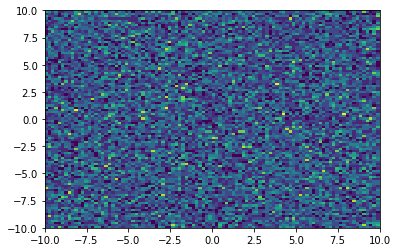

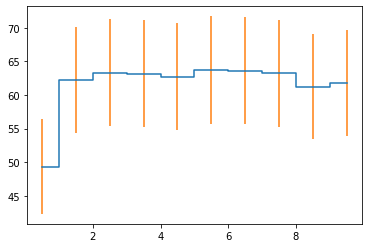

In [15]:
fig, ax = plt.subplots()

lim = 10
ax.hist2d(reco[:,0],reco[:,1],bins=100,range=((-lim,lim),(-lim,lim)));

r = np.sqrt(reco[:,0]**2 + reco[:,1]**2)
vals, binedges = np.histogram(r,bins=10,range=(0,lim))
vals = vals/(np.pi*(binedges[1:]**2 - binedges[:-1]**2))
bincenter = 0.5*(binedges[1:] + binedges[:-1])
# vals = vals/bincenter

fig, ax = plt.subplots()
ax.step(bincenter,vals,where='mid')
ax.errorbar(bincenter,vals,np.sqrt(vals),fmt='none')

In [16]:
N_samples = 2**5+1
int_lim = 4
LF1_2d, P_2d, P_obs, (X_grid,Y_grid), (X,Y) = fc.return_LF1_2d_and_P_2d(reco,sample.pred_sigma.values,N_samples, int_lim)
# LF1_2d, P_2d, P_obs, (X_grid,Y_grid), (X,Y) = fc.return_LF1_2d_and_P_2d(reco[weights >=0.01],sample.pred_sigma.values[weights >=0.01],N_samples, int_lim)

100%|██████████████████████████████████████████| 16/16 [00:04<00:00,  3.69it/s]


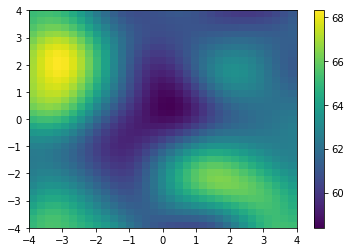

In [17]:
fig, ax = plt.subplots()

im = ax.pcolormesh(X_grid, Y_grid, P_obs.reshape(N_samples,N_samples))
fig.colorbar(im)

In [18]:
1 - P_obs.min()/P_obs.mean()

0.06817352018056422

In [19]:
a = sympy.Symbol('a')
b = sympy.Symbol('b')
s = sympy.Symbol('s')

m = sympy.Symbol('m')
p = sympy.Symbol('p')
c = sympy.Symbol('c')

# N = sympy.Symbol('N')
f = sympy.Symbol('f')
l = sympy.Symbol('l')

expr2 = sympy.sympify("(exp(-((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))*(f*s^2*exp((p^2*s^4+m^2*s^4+2*b*c^2*p*s^2+2*a*c^2*m*s^2+b^2*c^4+a^2*c^4)/(2*c^2*s^2*(s^2+c^2)))*erf((m*s^2+l*s^2+c^2*l+a*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))*erf((p*s^2+l*s^2+c^2*l+b*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))-f*s^2*exp((p^2*s^4+m^2*s^4+2*b*c^2*p*s^2+2*a*c^2*m*s^2+b^2*c^4+a^2*c^4)/(2*c^2*s^2*(s^2+c^2)))*erf((m*s^2-l*s^2-c^2*l+a*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))*erf((p*s^2+l*s^2+c^2*l+b*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))-f*s^2*exp((p^2*s^4+m^2*s^4+2*b*c^2*p*s^2+2*a*c^2*m*s^2+b^2*c^4+a^2*c^4)/(2*c^2*s^2*(s^2+c^2)))*erf((m*s^2+l*s^2+c^2*l+a*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))*erf((p*s^2-l*s^2-c^2*l+b*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))+f*s^2*exp((p^2*s^4+m^2*s^4+2*b*c^2*p*s^2+2*a*c^2*m*s^2+b^2*c^4+a^2*c^4)/(2*c^2*s^2*(s^2+c^2)))*erf((m*s^2-l*s^2-c^2*l+a*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))*erf((p*s^2-l*s^2-c^2*l+b*c^2)/(sqrt(2)*c*s*sqrt(s^2+c^2)))-erf((m+l)/(sqrt(2)*c))*erf((p+l)/(sqrt(2)*c))*s^2*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))+erf((m-l)/(sqrt(2)*c))*erf((p+l)/(sqrt(2)*c))*s^2*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))+erf((m+l)/(sqrt(2)*c))*erf((p-l)/(sqrt(2)*c))*s^2*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))-erf((m-l)/(sqrt(2)*c))*erf((p-l)/(sqrt(2)*c))*s^2*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))-c^2*erf((m+l)/(sqrt(2)*c))*erf((p+l)/(sqrt(2)*c))*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))+c^2*erf((m-l)/(sqrt(2)*c))*erf((p+l)/(sqrt(2)*c))*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))+c^2*erf((m+l)/(sqrt(2)*c))*erf((p-l)/(sqrt(2)*c))*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))-c^2*erf((m-l)/(sqrt(2)*c))*erf((p-l)/(sqrt(2)*c))*exp(((p^2+m^2)*s^2+(b^2+a^2)*c^2)/(2*c^2*s^2))))/(2*(s^2+c^2)*(pi*f*(erf((l+a)/(sqrt(2)*s))+erf((l-a)/(sqrt(2)*s)))*(erf((l+b)/(sqrt(2)*s))+erf((l-b)/(sqrt(2)*s)))*s^2-8*l^2))")
# func = sympy.lambdify((a,b,s,m,p,c,f,l),expr2)
numpy_func = np.vectorize(sympy.lambdify((a,b,s,m,p,c,f,l),expr2))

In [31]:
# numpy_func
import timeit

number = 20_000

timeit.timeit(lambda : numpy_func(0,0,1,reco[:number,0],reco[:number,1],sample.pred_sigma.iloc[:number],0.5,4),number=5)

26.376896999999985

In [32]:
scheme = quadpy.c2.get_good_scheme(21) #c2

def wrapper(xy_reco, xy_sigma, lim, weight_cut=0):
    
    def gauss2d(x,y,mus,sigmas):
        xy = (np.vstack((x,y,)).T).reshape(-1,2,1)
        mus = mus.T.reshape(1,2,-1)
        sigmas = sigmas.reshape(1,-1)
        z_sqrd = (((xy - mus)/sigmas)**2).sum(1)
        return np.exp(-0.5*z_sqrd)/(2*np.pi*sigmas**2)
    
    def P_2d(x,y,mu_x,mu_y,sigma,f):
        z_sqrd = ((x-mu_x)**2 + (y - mu_y)**2)/ sigma**2
        norm = 4*lim**2 - 0.5*np.pi*f*sigma**2*(\
                                                (erf((lim + mu_x)/(np.sqrt(2)*sigma)) - erf((-lim + mu_x)/(np.sqrt(2)*sigma)))\
                                                *(erf((lim + mu_y)/(np.sqrt(2)*sigma))-erf((-lim + mu_y)/(np.sqrt(2)*sigma))))
        return (1 - f*np.exp(-0.5*z_sqrd))/norm
    
    def calc_weights():
        x, y = xy_reco[:,0], xy_reco[:,1]
        r = np.sqrt(x**2 + y**2)
#         w = np.ones(r.shape[0])
        w = 0.5*np.pi*xy_sigma**2*(\
                              (erf((lim + x)/(np.sqrt(2)*xy_sigma)) - erf((-lim + x)/(np.sqrt(2)*xy_sigma)))\
                              *(erf((lim + y)/(np.sqrt(2)*xy_sigma))-erf((-lim + y)/(np.sqrt(2)*xy_sigma))))/(2*np.pi*xy_sigma**2)
        return w
    
    weights = calc_weights()
    
    weight_mask = weights >= weight_cut
    
    xy_reco = xy_reco[weight_mask]
    xy_sigma = xy_sigma[weight_mask]
    unmasked_weights = weights.copy()
    weights = weights[weight_mask]
    
    def LF2_2d(mu_x,mu_y,sigma,f):
        def integrand(x_y):
            x, y = x_y
            tmp = P_2d(x,y,mu_x,mu_y,sigma,f).T*gauss2d(x,y,xy_reco,xy_sigma).T
            return tmp
        vals = numpy_func(mu_x,mu_y,sigma,xy_reco[:,0],xy_reco[:,1],xy_sigma,f,lim)
#         vals = scheme.integrate(integrand,np.array([[[-lim, -lim], [lim, -lim]], [[-lim, lim], [lim, lim]]]))
        loss = -np.sum(weights*np.log(vals))
        fc.Print(loss)
        return loss
    return LF2_2d, P_2d, unmasked_weights

In [33]:
int_lim = 4
LF2_2d, P_2d, weights = wrapper(reco,sample.pred_sigma.values,int_lim,weight_cut=0.01)
obj2 = fc.integratedLH(LF2_2d)
M2 = Minuit(obj2,mu_x=0,mu_y=0,sigma=1,f=0.07, 
            limit_mu_x=(-int_lim,int_lim),limit_mu_y=(-int_lim,int_lim),limit_sigma=(0,None),limit_f=(0,1),
            fix_sigma=False,fix_f=False)

Text(0.5, 1.0, '10404')

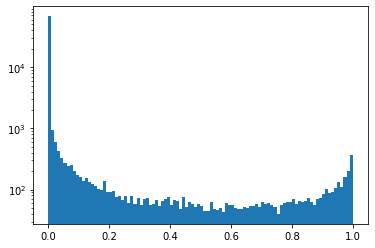

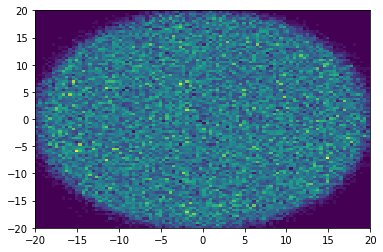

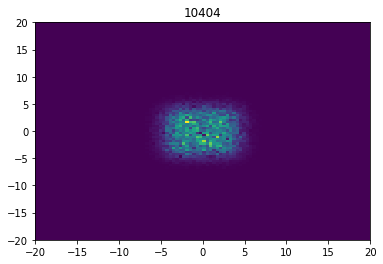

In [34]:
fig, ax = plt.subplots()
ax.hist(weights,bins=100);
ax.set_yscale('log')

range_lim = 20
range_lims = ((-range_lim,range_lim),(-range_lim,range_lim))

plt.figure()
plt.hist2d(reco[:,0],reco[:,1],bins=bins,range=range_lims);

plt.figure()
mask = weights >=0.01
plt.hist2d(reco[mask,0],reco[mask,1],bins=bins,weights=weights[mask],range=range_lims);
plt.title(mask.sum())

In [35]:
M2.migrad()

12:35:03 - 18690.26005041868
12:35:06 - 18690.25975889025
12:35:08 - 18690.26035491533
12:35:11 - 18690.25771578877
12:35:13 - 18690.263680880125
12:35:15 - 18690.259461810474
12:35:18 - 18690.26064580607
12:35:20 - 18690.254472241162
12:35:22 - 18690.266305991554
12:35:25 - 18690.260190049637
12:35:27 - 18690.259911085777
12:35:29 - 18690.261459827125
12:35:32 - 18690.258670821484
12:35:34 - 18690.25979485265
12:35:36 - 18690.260305905562
12:35:38 - 18690.257491206743
12:35:40 - 18690.262601715862
12:35:43 - 18690.257491206743
12:35:45 - 18690.247176429893
12:35:47 - 18690.2208657191
12:35:49 - 18690.138019838545
12:35:52 - 18689.87189923773
12:35:54 - 18689.5841976529
12:35:56 - 18689.52057706595
12:35:59 - 18689.50209942164
12:36:01 - 18689.496695989303
12:36:03 - 18689.49192309004
12:36:06 - 18689.589731029595
12:36:08 - 18689.485736440707
12:36:10 - 18689.516612796193
12:36:12 - 18689.40575276709
12:36:15 - 18689.700525033644
12:36:17 - 18689.45950774253
12:36:19 - 18689.542888680

------------------------------------------------------------------
| FCN = 1.869e+04               |     Ncalls=252 (252 total)     |
| EDM = 1.74e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu_x  |    0.1    |    0.5    |            |            |   -4    |    4    |       |
| 1 | mu_y  |    0.5    |    0.6    |            |            |   -4    |    4    |       |
| 2 | sigma |   0.47    |   0.12    |            |            |    0    |         |       |
| 3 | f     |     1     |     1     |            |            |    0    |    1    |       |
-------------------------------------------------------------------------------------------

In [71]:
min_mask = P_obs.reshape(N_samples,N_samples)==P_obs.reshape(N_samples,N_samples).min()
X[min_mask],Y[min_mask]

(array([0.24242424]), array([0.48484848]))

In [83]:
M2.args

<ArgsView of Minuit at 2882a4c3e88>
  -1.9206397555960777
  -0.00036351703671666513
  0.7684520837092352
  0.9999999981468477

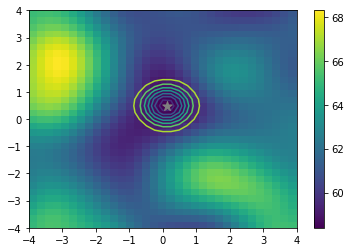

In [37]:
fig, ax = plt.subplots()

im = ax.pcolormesh(X_grid, Y_grid, P_obs.reshape(N_samples,N_samples))
ax.scatter(M2.args[0],M2.args[1],c='grey',marker='*',s=100,zorder=10)

h_loss = P_2d(X.flatten(),Y.flatten(),*M2.args)
ax.contour(X,Y,h_loss.reshape(N_samples,N_samples))
fig.colorbar(im)

12:53:35 - 18690.55224765059
12:53:38 - 18690.55224765059
12:53:40 - 18690.55224765059
12:53:42 - 18690.55224765059
12:53:45 - 18690.55224765059
12:53:47 - 18690.55224765059
12:53:49 - 18690.55224765059
12:53:52 - 18690.55224765059
12:53:54 - 18690.55224765059
12:53:56 - 18690.55224765059
12:53:59 - 18690.55224765059
12:54:01 - 18690.55224765059
12:54:03 - 18690.55224765059
12:54:06 - 18690.55224765059
12:54:08 - 18690.55224765059
12:54:10 - 18690.55224765059
12:54:13 - 18690.55224765059
12:54:16 - 18690.55224765059


C:\Users\jv97\anaconda3\lib\site-packages\ipykernel_launcher.py:2: IMinuitWarning: MIGRAD fails to converge for f=0.000000
  


12:54:18 - 18689.47285699162
12:54:21 - 18689.474749550056
12:54:23 - 18689.472962043215
12:54:25 - 18689.47919595817
12:54:28 - 18689.475417882695
12:54:30 - 18689.472920930162
12:54:32 - 18689.474854103795
12:54:35 - 18689.475179325374
12:54:37 - 18689.479435599922
12:54:39 - 18689.433306478568
12:54:42 - 18689.512299210935
12:54:44 - 18689.11873540665
12:54:46 - 18689.81876310202
12:54:49 - 18689.11873540665
12:54:51 - 18688.54464374926
12:54:53 - 18688.51687975022
12:54:56 - 18688.496871511634
12:54:58 - 18688.529931224813
12:55:01 - 18688.486550660462
12:55:03 - 18688.514974570717
12:55:05 - 18688.4876856881
12:55:08 - 18688.498770386268
12:55:10 - 18688.516488176385
12:55:12 - 18688.495723164036
12:55:15 - 18688.506938835584
12:55:17 - 18688.564595130803
12:55:19 - 18688.578422297924
12:55:22 - 18688.499830200755
12:55:24 - 18688.50295570414
12:55:26 - 18688.487104301876
12:55:29 - 18688.48662136455
12:55:31 - 18688.49203797473
12:55:33 - 18688.490567364577
12:55:36 - 18688.49294

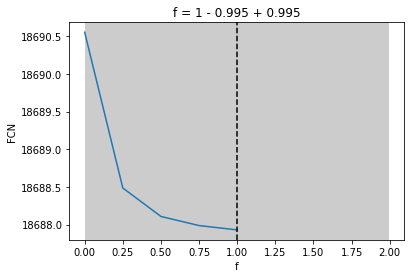

In [60]:
plt.figure()
M2.draw_mnprofile('f',5,(0,1));

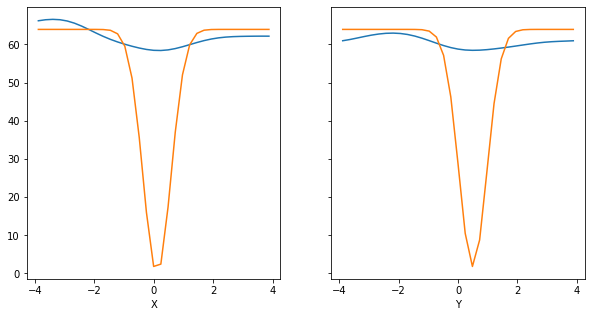

In [46]:
loc = (M2.values['mu_x'],M2.values['mu_y'])
row = np.abs(Y-loc[1]).argmin(0)[0]
col = np.abs(X-loc[0]).argmin(1)[0]

# norm = scheme.integrate(lambda x_y: 1 - M2.values['f']*np.exp(-0.5*((x_y[0]-M2.values['mu_x'])**2 + (x_y[1] - M2.values['mu_y'])**2)/ M2.values['sigma']**2),[0.0,0.0],int_lim)
norm = scheme.integrate(lambda x_y: 1 - M2.values['f']*np.exp(-0.5*((x_y[0]-M2.values['mu_x'])**2 + (x_y[1] - M2.values['mu_y'])**2)/ M2.values['sigma']**2),np.array([[[-int_lim, -int_lim], [int_lim, -int_lim]], [[-int_lim, int_lim], [int_lim, int_lim]]]))

multiplier = 1/P_2d(X[:,col],Y[:,col],0,0,1,0.02).max()

fig, ax = plt.subplots(figsize=(10,5),ncols=2,sharey=True)
tmp = P_obs.reshape(N_samples,N_samples)
ax[0].set_xlabel('X')
ax[0].plot(X[row,:],tmp[row,:])
# ax[0].plot(X[row,:],P_2d(X[row,:],Y[row],*M2.args)*(4*int_lim**2 - M2.values['f']*M2.values['sigma']**2*2*np.pi*erf(int_lim/(np.sqrt(2)*M2.values['sigma']))**2)*tmp.mean())
ax[0].plot(X[row,:],P_2d(X[row,:],Y[row],*M2.args)*tmp.mean()*multiplier);
ax[1].set_xlabel('Y')
ax[1].plot(Y[:,col],tmp[:,col])
# ax[1].plot(Y[:,col],P_2d(X[:,col],Y[:,col],*M2.args)*(4*int_lim**2 - M2.values['f']*M2.values['sigma']**2*2*np.pi*erf(int_lim/(np.sqrt(2)*M2.values['sigma']))**2)*tmp.mean());
ax[1].plot(Y[:,col],P_2d(X[:,col],Y[:,col],*M2.args)*tmp.mean()*multiplier);
# ax[1].plot(Y[:,col],P_2d(X[:,col],Y[:,col],0,0,1,0.02)*tmp.mean()*multiplier);

In [72]:
N = 500_000
xw = 20

signal = np.random.uniform(-xw,xw,(N,2))#(np.random.uniform((N,2)) - 0.5)*2*xw
r = np.sqrt(signal[:,0]**2 + signal[:,1]**2)
mask = (r > 0.5)&(r<xw)
signal = signal[mask]

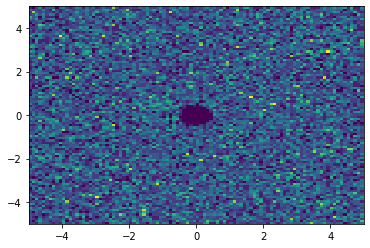

In [73]:
fig, ax = plt.subplots()
lim = 5
ax.hist2d(signal[:,0],signal[:,1],bins=100,range=((-lim,lim),(-lim,lim)));

In [74]:
N = signal.shape[0]
reco = signal.copy()
sample = sample2d(df[['solidA','pred_sigma']][df.pred_sigma<=cut],N,noise=0.001)
# print("DOWNSCALING FOR TESTING, SHOULD BE REMOVED IN FINAL REENDITION")
# sample = sample2d(df[['solidA','pred_sigma']][df.pred_sigma<=cut],N,noise=0.001)*0.5
deviation = fan_out(sample.solidA.to_numpy())
reco += deviation

<ErrorbarContainer object of 3 artists>

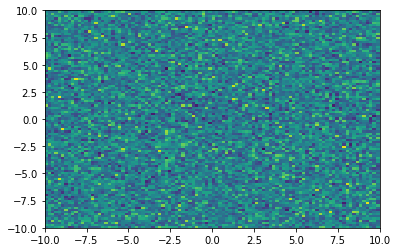

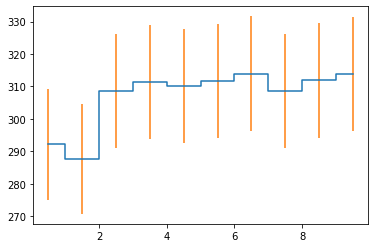

In [75]:
fig, ax = plt.subplots()

lim = 10
ax.hist2d(reco[:,0],reco[:,1],bins=100,range=((-lim,lim),(-lim,lim)));

r = np.sqrt(reco[:,0]**2 + reco[:,1]**2)
vals, binedges = np.histogram(r,bins=10,range=(0,lim))
vals = vals/(np.pi*(binedges[1:]**2 - binedges[:-1]**2))
bincenter = 0.5*(binedges[1:] + binedges[:-1])
# vals = vals/bincenter

fig, ax = plt.subplots()
ax.step(bincenter,vals,where='mid')
ax.errorbar(bincenter,vals,np.sqrt(vals),fmt='none')

In [79]:
N_samples = 2**5+1
int_lim = 8
LF1_2d, P_2d, P_obs, (X_grid,Y_grid), (X,Y) = fc.return_LF1_2d_and_P_2d(reco,sample.pred_sigma.values,N_samples, int_lim)

100%|██████████████████████████████████████████| 79/79 [00:25<00:00,  3.13it/s]


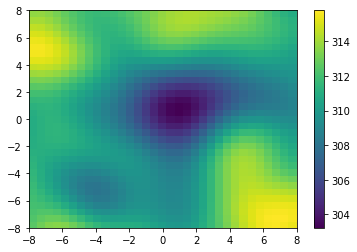

In [82]:
fig, ax = plt.subplots()

im = ax.pcolormesh(X_grid, Y_grid, P_obs.reshape(N_samples,N_samples))
fig.colorbar(im)

In [83]:
1 - P_obs.min()/P_obs.mean()

0.023624002926172838

In [86]:
int_lim = 6
LF2_2d, P_2d, weights = wrapper(reco,sample.pred_sigma.values,int_lim,weight_cut=0.01)
obj2 = fc.integratedLH(LF2_2d)
M2 = Minuit(obj2,mu_x=0,mu_y=0,sigma=1,f=0.023, 
            limit_mu_x=(-int_lim,int_lim),limit_mu_y=(-int_lim,int_lim),limit_sigma=(0,None),limit_f=(0,1),
            fix_sigma=False,fix_f=False)

Text(0.5, 1.0, '143622')

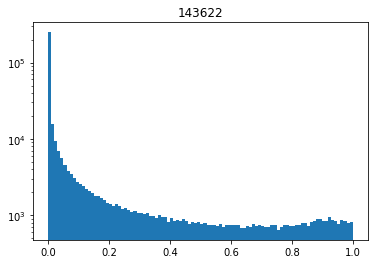

In [87]:
fig, ax = plt.subplots()
ax.hist(weights,bins=100);
ax.set_yscale('log')
mask = weights >=0.01
ax.set_title(mask.sum())

In [88]:
M2.migrad()

14:18:20 - 250893.12728115
14:18:53 - 250893.12349660878
14:19:25 - 250893.13120207004
14:19:57 - 250893.09604503957
14:20:31 - 250893.1720867694
14:21:05 - 250893.12396651303
14:21:40 - 250893.13073932813
14:22:14 - 250893.10099269883
14:22:48 - 250893.16784135718
14:23:22 - 250893.1254819031
14:23:55 - 250893.12908356087
14:24:29 - 250893.10944467387
14:25:03 - 250893.14543390952
14:25:37 - 250893.12600569925
14:26:10 - 250893.12855499575
14:26:44 - 250893.11445493528
14:27:18 - 250893.13994686055
14:27:52 - 250893.11445493528
14:28:26 - 250893.06160922712
14:28:59 - 250892.91989833603
14:29:32 - 250892.44672066285
14:30:04 - 250891.74197362794
14:30:38 - 250891.90587000843
14:31:11 - 250891.68875247048
14:31:44 - 250891.67827270582
14:32:17 - 250891.32970662825
14:32:50 - 250893.16000733664
14:33:23 - 250891.4096743146
14:33:56 - 250892.07061410093
14:34:31 - 250891.45538475816
14:35:05 - 250893.03017379454
14:35:39 - 250891.4568051933
14:36:12 - 250892.0239283821
14:36:46 - 250893.

------------------------------------------------------------------
| FCN = 2.509e+05               |     Ncalls=224 (224 total)     |
| EDM = 0.000259 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | mu_x  |    0.9    |    0.7    |            |            |   -6    |    6    |       |
| 1 | mu_y  |    0.7    |    0.7    |            |            |   -6    |    6    |       |
| 2 | sigma |   0.48    |   0.14    |            |            |    0    |         |       |
| 3 | f     |     1     |     1     |            |            |    0    |    1    |       |
-------------------------------------------------------------------------------------------

In [98]:
M2.args, M2.errors

(<ArgsView of Minuit at 228c3dbd138>
   0.889705190851843
   0.7253221842928053
   0.4752671200232963
   0.9999999907718966,
 <ErrorView of Minuit at 228c3dbd138>
   mu_x: 0.7208468302924289
   mu_y: 0.6871658559359588
   sigma: 0.13984467148045443
   f: 0.999704889975459)

In [94]:
min_mask = P_obs.reshape(N_samples,N_samples)==P_obs.reshape(N_samples,N_samples).min()
X[min_mask],Y[min_mask]

(array([0.96969697]), array([0.96969697]))

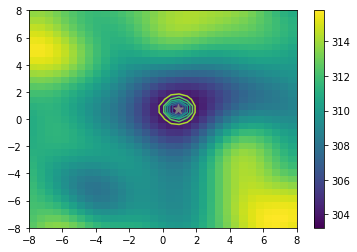

In [89]:
fig, ax = plt.subplots()

im = ax.pcolormesh(X_grid, Y_grid, P_obs.reshape(N_samples,N_samples))
ax.scatter(M2.args[0],M2.args[1],c='grey',marker='*',s=100,zorder=10)

h_loss = P_2d(X.flatten(),Y.flatten(),*M2.args)
ax.contour(X,Y,h_loss.reshape(N_samples,N_samples))
fig.colorbar(im)

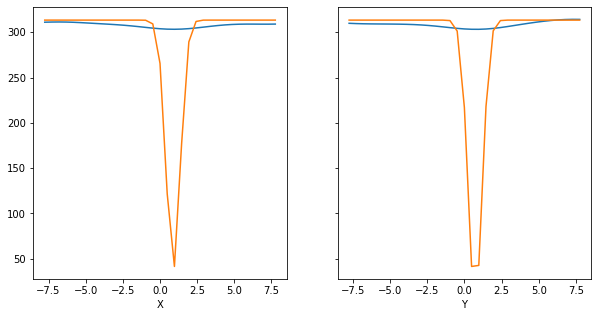

In [96]:
loc = (M2.values['mu_x'],M2.values['mu_y'])
row = np.abs(Y-loc[1]).argmin(0)[0]
col = np.abs(X-loc[0]).argmin(1)[0]

# norm = scheme.integrate(lambda x_y: 1 - M2.values['f']*np.exp(-0.5*((x_y[0]-M2.values['mu_x'])**2 + (x_y[1] - M2.values['mu_y'])**2)/ M2.values['sigma']**2),[0.0,0.0],int_lim)
norm = scheme.integrate(lambda x_y: 1 - M2.values['f']*np.exp(-0.5*((x_y[0]-M2.values['mu_x'])**2 + (x_y[1] - M2.values['mu_y'])**2)/ M2.values['sigma']**2),np.array([[[-int_lim, -int_lim], [int_lim, -int_lim]], [[-int_lim, int_lim], [int_lim, int_lim]]]))

multiplier = 1/P_2d(X[:,col],Y[:,col],0,0,1,0.02).max()

fig, ax = plt.subplots(figsize=(10,5),ncols=2,sharey=True)
tmp = P_obs.reshape(N_samples,N_samples)
ax[0].set_xlabel('X')
ax[0].plot(X[row,:],tmp[row,:])
# ax[0].plot(X[row,:],P_2d(X[row,:],Y[row],*M2.args)*(4*int_lim**2 - M2.values['f']*M2.values['sigma']**2*2*np.pi*erf(int_lim/(np.sqrt(2)*M2.values['sigma']))**2)*tmp.mean())
ax[0].plot(X[row,:],P_2d(X[row,:],Y[row],*M2.args)*tmp.mean()*multiplier);
ax[1].set_xlabel('Y')
ax[1].plot(Y[:,col],tmp[:,col])
# ax[1].plot(Y[:,col],P_2d(X[:,col],Y[:,col],*M2.args)*(4*int_lim**2 - M2.values['f']*M2.values['sigma']**2*2*np.pi*erf(int_lim/(np.sqrt(2)*M2.values['sigma']))**2)*tmp.mean());
ax[1].plot(Y[:,col],P_2d(X[:,col],Y[:,col],*M2.args)*tmp.mean()*multiplier);
# ax[1].plot(Y[:,col],P_2d(X[:,col],Y[:,col],0,0,1,0.02)*tmp.mean()*multiplier);

In [149]:
# import pickle
# with open('samples/run1_minuit_ArgsErrors.pkl', 'wb') as output:
#     pickle.dump([dict(M2.values), dict(M2.errors)],output,pickle.HIGHEST_PROTOCOL)

In [116]:
# np.save('samples/run1_RecoSigma_N393k.npy',np.concatenate([reco,sample.pred_sigma.values.reshape(-1,1)],axis=1))

In [150]:
# with open('samples/run1_minuit_ArgsErrors.pkl', 'rb') as read:
#     tmp_M = pickle.load(read)